In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import ndimage
from scipy.fft import fft, fftfreq
from scipy.interpolate import approximate_taylor_polynomial, interp1d
from astropy.units import Quantity
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from sklearn.cluster import DBSCAN
from scipy.signal import find_peaks

%matplotlib inline

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 140

In [2]:
def normalise(data):
    max_val = max(data)
    min_val = min(data)
    from_zero = data - min_val
    data_range = max_val - min_val
    to_return = []
    if data_range == 0:
        print("RANGE IS ZERO; SKIPING")
        print(data)
        print(data_range)
        return data
    return np.nan_to_num((data - min_val) / data_range, nan=0)

def average(data):
    data = np.nan_to_num(data, nan=0)
    return sum(data) / len(data)

def moving_average(data, n=5):
    rolling_averages = []
    for i in range(len(data) + n):
        from_i = max(0, min(i - round(n / 2), len(data) - 1))
        to_i = min(len(data) - 1, i + round(n / 2))
        sample = np.array([data[from_i]]) if to_i <= from_i else data[from_i:to_i]
        rolling_averages.append(average(sample))
    return np.array(rolling_averages)


def moving_average_same_dimensions(data, n=5):
    rolling_averages = []
    for i in range(len(data)):
        from_i = max(0, min(i - round(n / 2), len(data) - 1))
        to_i = min(len(data) - 1, i + round(n / 2))
        sample = np.array([data[from_i]]) if to_i <= from_i else data[from_i:to_i]
        rolling_averages.append(average(sample))
    return np.array(rolling_averages)

def clean_nan_from_ts(times, fluxes):
    nans = np.where(np.isnan(fluxes))[0]
    for to_remove in reversed(nans):
        times = np.delete(times, to_remove)
        fluxes = np.delete(fluxes, to_remove)
    return (times, fluxes)

def remove_outliers(times, fluxes):
    to_remove = np.where(fluxes > 2)[0]
    for i in reversed(to_remove):
        times = np.delete(times, i)
        fluxes = np.delete(fluxes, i)
    return (times, fluxes)

In [3]:
def perform_fft(x, y, T, plottimeseries=True, plotfrequencies=True):
    if plottimeseries:
        plot_ts(x,y)
    N = len(x)
    frequencies = fftfreq(N, T)
    # second half of freqs is -ve. We can ignore this as it is symmetrical
    frequencies = frequencies[:N//2] 

    transformed = fft(flattened_curve)
    # take only first half as is symmetrical for -ve numbers and we can ignore.
    transformed = np.abs(transformed[:N//2])
    
    if plotfrequencies:
        freq_fig, freq_ax = plt.subplots()
        freq_ax.bar(frequencies, 2.0 / N * transformed, width=0.05)
        freq_ax.xaxis.set_major_locator(MultipleLocator(10))
        freq_ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        freq_ax.grid(which='major', color='#CCCCCC', linestyle='--')
        freq_ax.grid(which='minor', color='#CCCCCC', linestyle=':')
    return (frequencies, transformed)

def gaussian_smooth(x, sigma=2):
    return ndimage.gaussian_filter1d(x, sigma)

def plot_ts(x,y):
    fig, ax = plt.subplots()
    ax.plot(x,y,'k.',markersize=1)

In [4]:
kepler_id = 12557548
search_result = lk.search_lightcurve(f'K2-237')
# search_result = lk.search_lightcurve(f'Kepler-10', author='Kepler')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,K2 Campaign 11a,2016,K2,1800,ktwo229426032,0.0
1,K2 Campaign 11b,2016,K2,1800,ktwo229426032,0.0
2,K2 Campaign 111,2016,EVEREST,1800,ktwo229426032,0.0
3,K2 Campaign 112,2016,EVEREST,1800,ktwo229426032,0.0
4,K2 Campaign 111,2016,K2SFF,1800,ktwo229426032,0.0
5,K2 Campaign 112,2016,K2SFF,1800,ktwo229426032,0.0
6,TESS Sector 12,2019,SPOC,120,16288184,0.0
7,TESS Sector 39,2021,SPOC,20,16288184,0.0
8,TESS Sector 39,2021,SPOC,120,16288184,0.0


In [5]:
search_result[0]

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,K2 Campaign 11a,2016,K2,1800,ktwo229426032,0.0


In [6]:
lightcurves = search_result[0].download_all()
# lightcurves.stitch().scatter()

# lightcurve_prefiltered = lightcurves.stitch()

# for i in range(len(lightcurves)):
#     lightcurves[i] = lightcurves[i].remove_outliers()

# lightcurve_postfiltered = lightcurves.stitch()
# lightcurve_postfiltered = lightcurve_postfiltered.remove_outliers()
# lightcurve_postfiltered.scatter()

# lightcurve_prefiltered.scatter()
# lightcurve_prepostfiltered = lightcurve_prefiltered.remove_outliers()
# lightcurve_prepostfiltered.scatter()
# lightcurve_postfiltered.scatter()

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

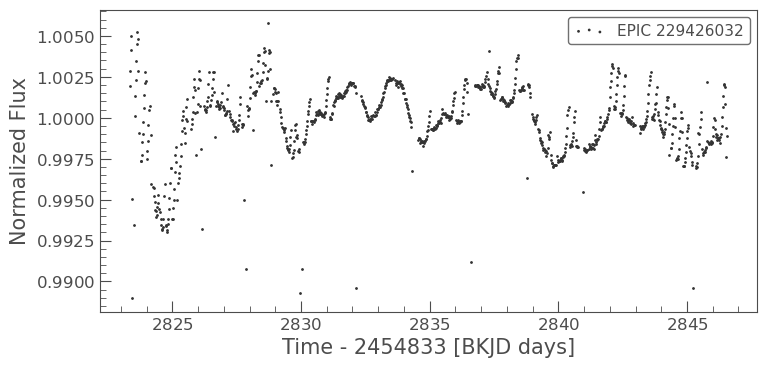

In [7]:
lightcurve = lightcurves.stitch().remove_outliers()
fluxes = lightcurve['flux'].unmasked.value
fluxes = fluxes[~np.isnan(fluxes)]
lightcurve.scatter()

0.011876778418593659


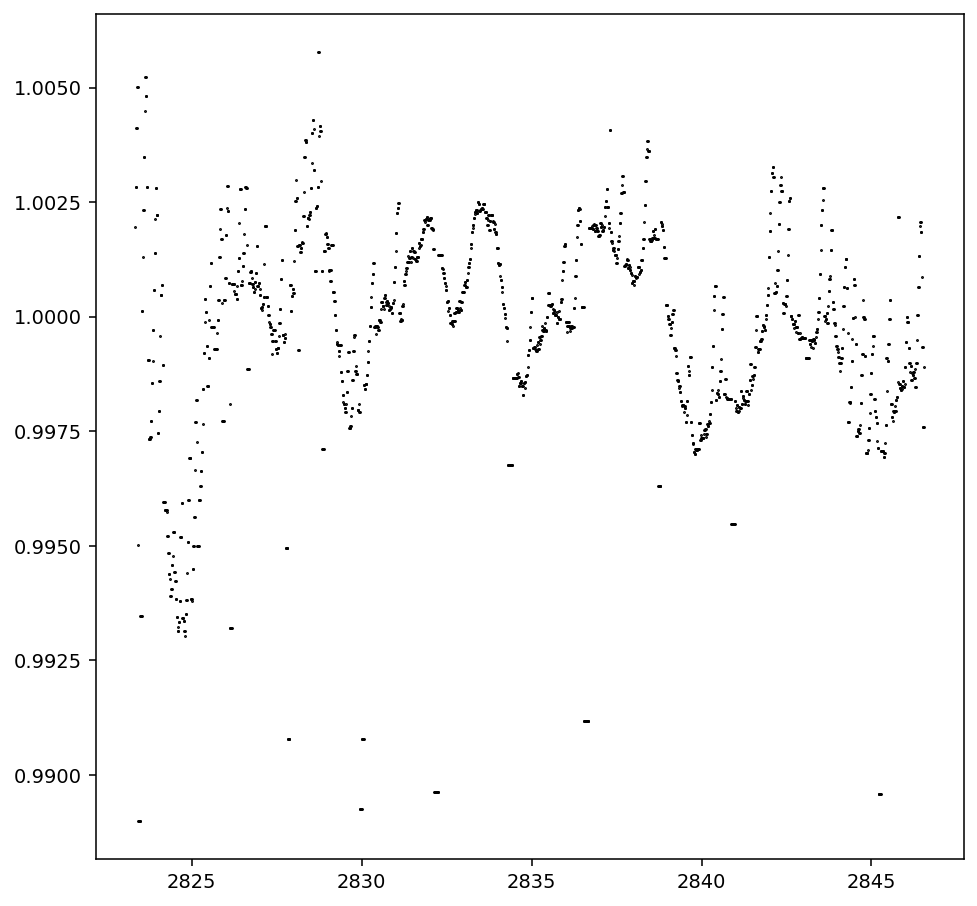

In [8]:
times = lightcurve['time'].value
period = []
for i in range(1, len(times)):
    period.append(times[i] - times[i - 1])
period = average(period) / 2

print(period)

new_x = np.arange(times[0], times[-1], period)
f = interp1d(x=times, y=fluxes, kind='nearest')

interpold = f(new_x)

plot_ts(new_x, interpold)

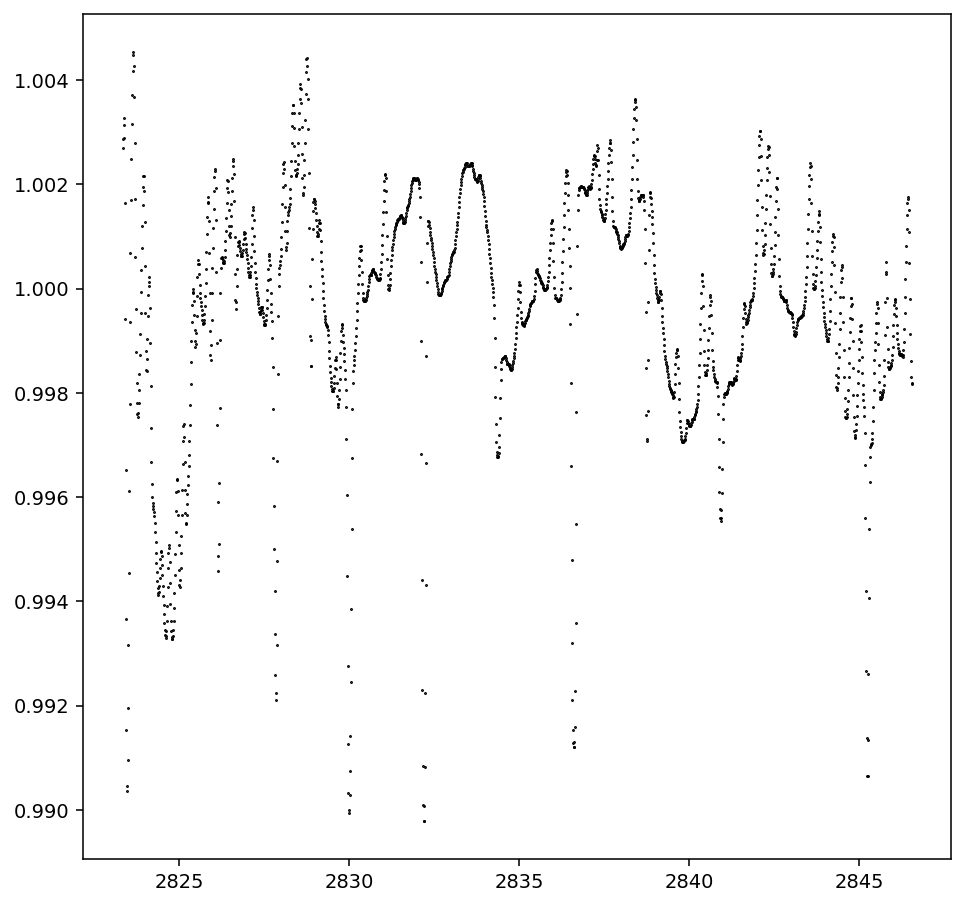

In [9]:
sigma = 2
gaussian_smoothed = ndimage.gaussian_filter1d(interpold, sigma)
plot_ts(new_x, gaussian_smoothed)

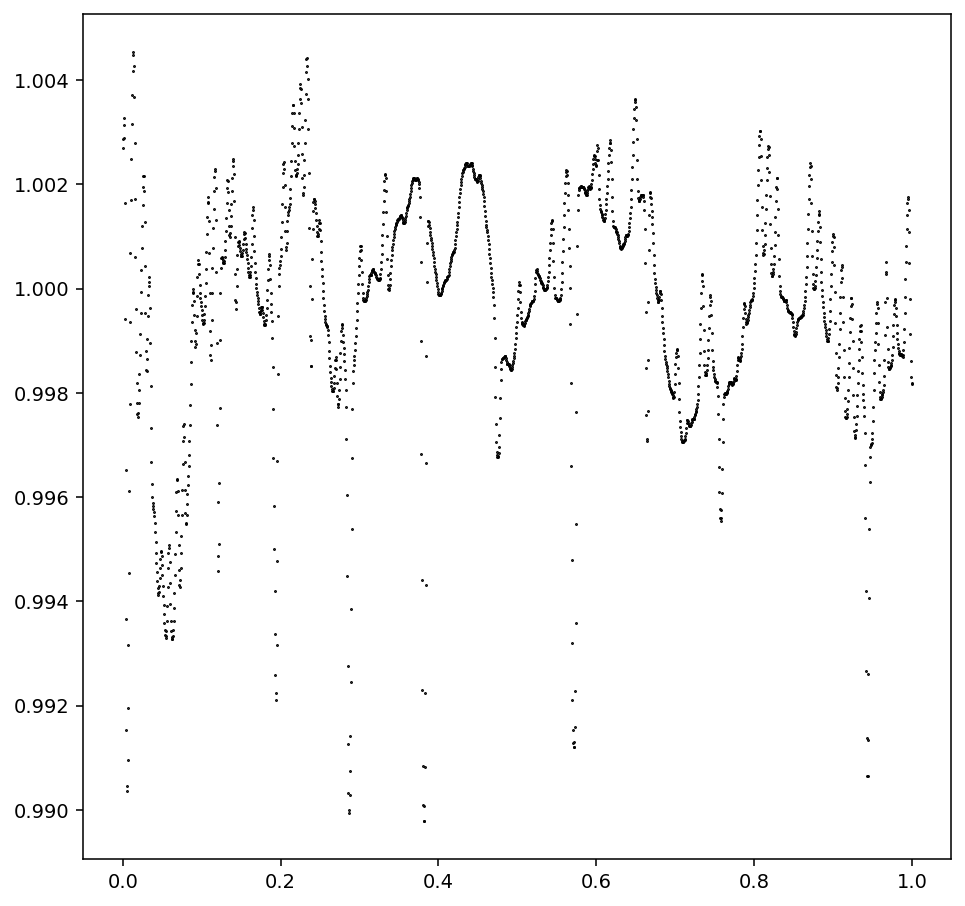

In [20]:
plot_ts(newnew_x, gaussian_smoothed)

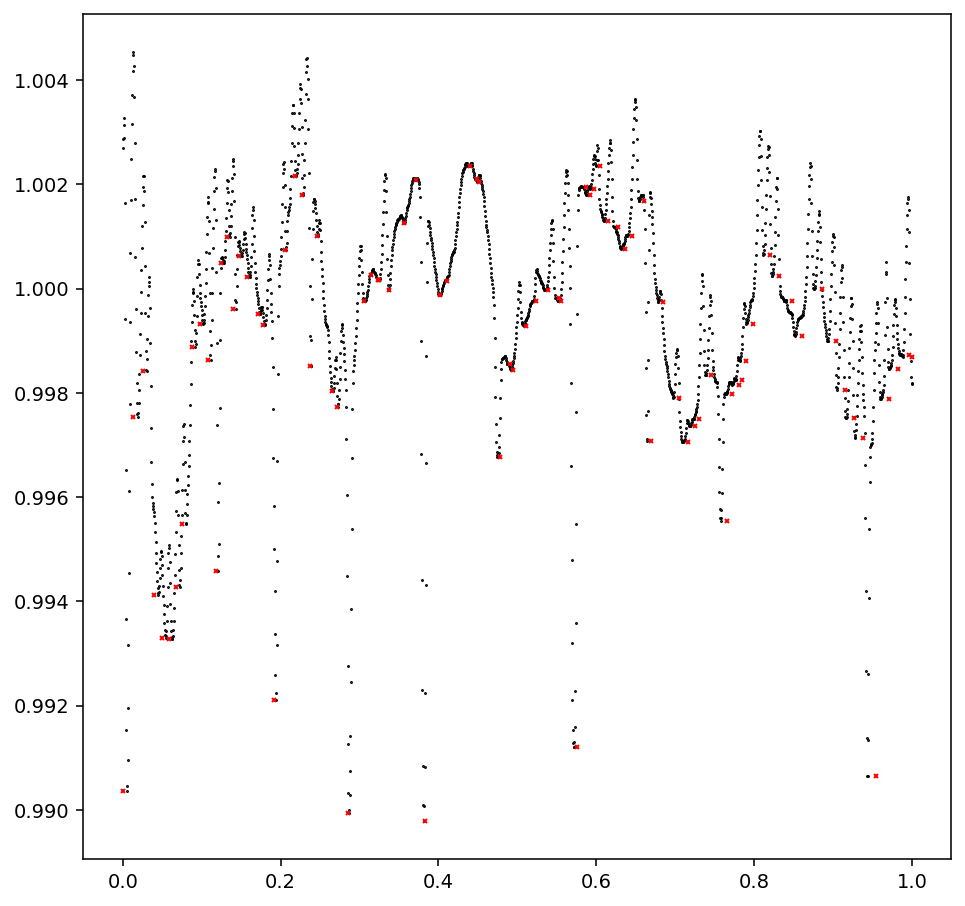

In [23]:
peaks, properties = find_peaks(gaussian_smoothed*-1)
fig, ax = plt.subplots()
ax.plot(newnew_x, gaussian_smoothed, 'k.', markersize=1)
ax.plot((peaks - peaks[0] + 1) / (peaks[-1]-peaks[0]), gaussian_smoothed[peaks], 'rx', markersize=2)

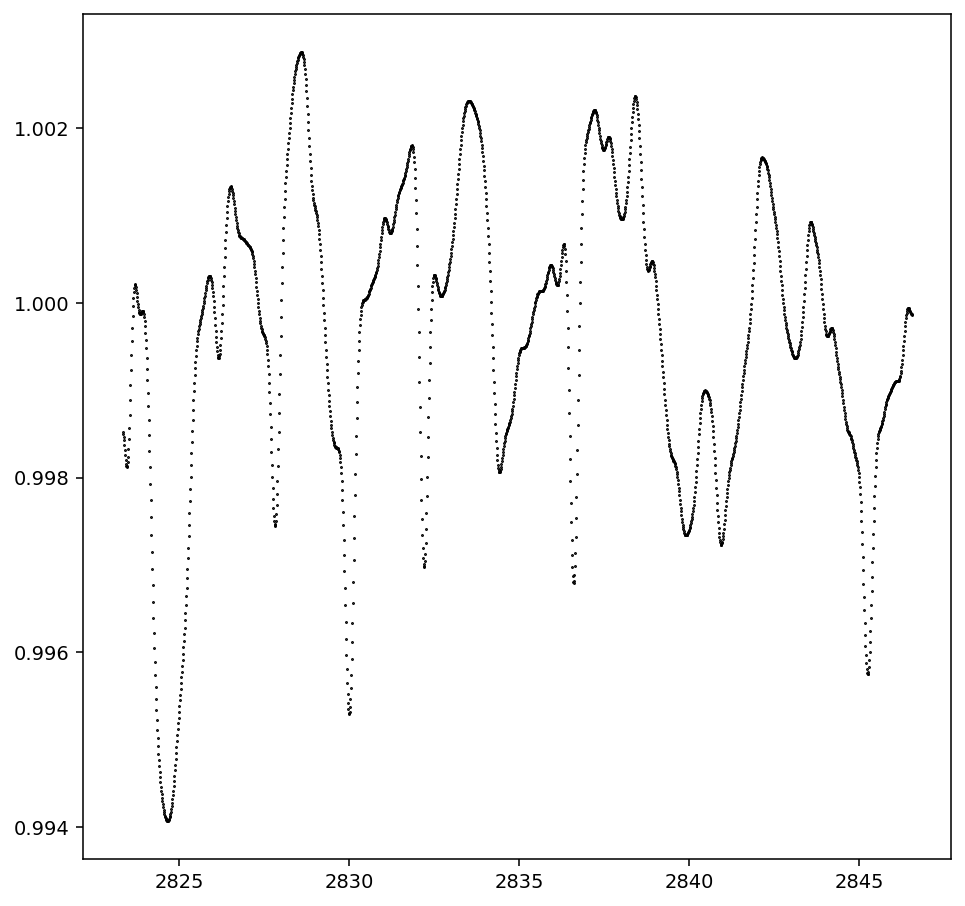

In [24]:
sigma = 10
gaussian_supersmooth = gaussian_smooth(interpold, sigma)
plot_ts(new_x, gaussian_supersmooth)

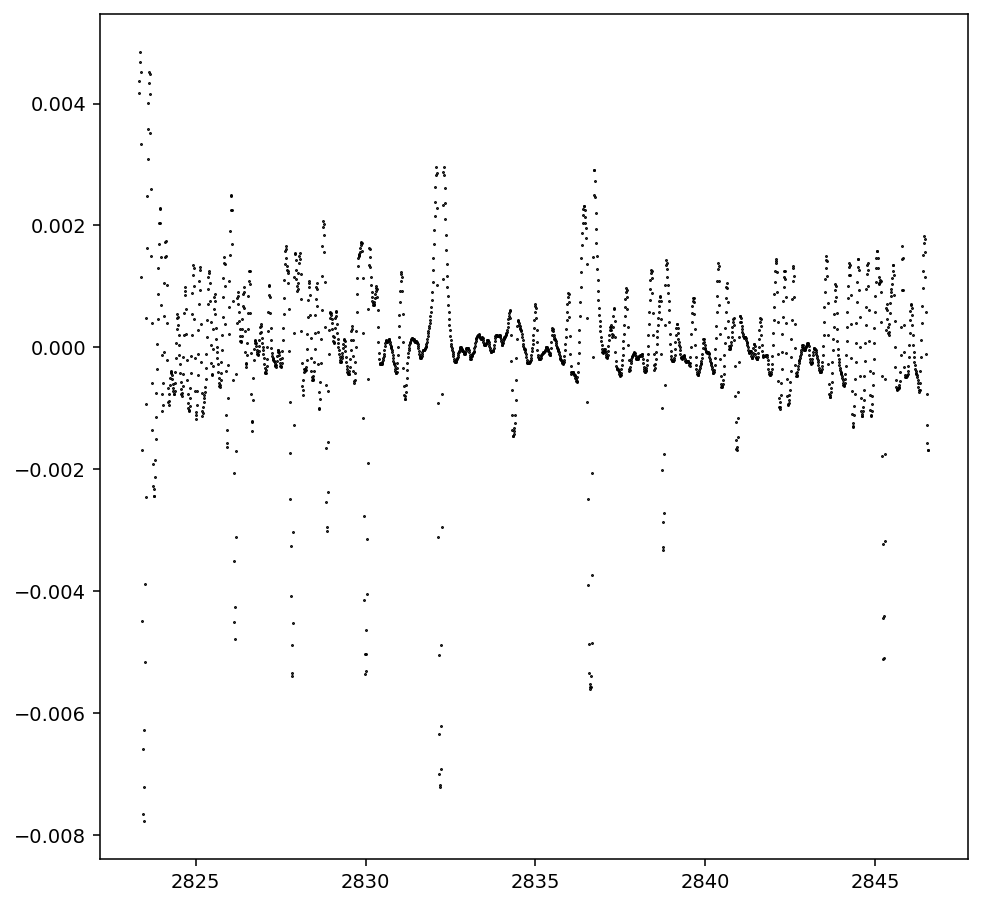

In [43]:
flattened_curve = gaussian_smoothed - gaussian_supersmooth
plot_ts(new_x, flattened_curve)

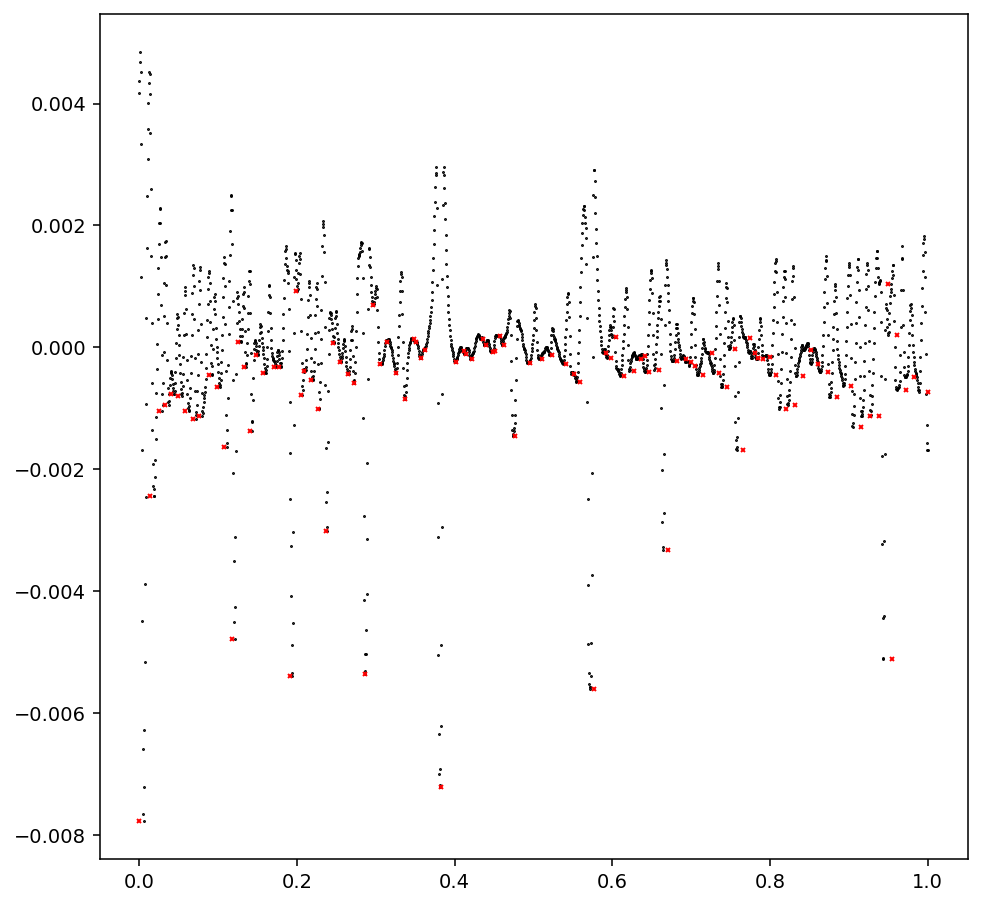

In [30]:
peaks, properties = find_peaks(flattened_curve*-1)
fig, ax = plt.subplots()
ax.plot(newnew_x, flattened_curve, 'k.', markersize=1)
ax.plot((peaks - peaks[0] + 1) / (peaks[-1]-peaks[0]), flattened_curve[peaks], 'rx', markersize=2)

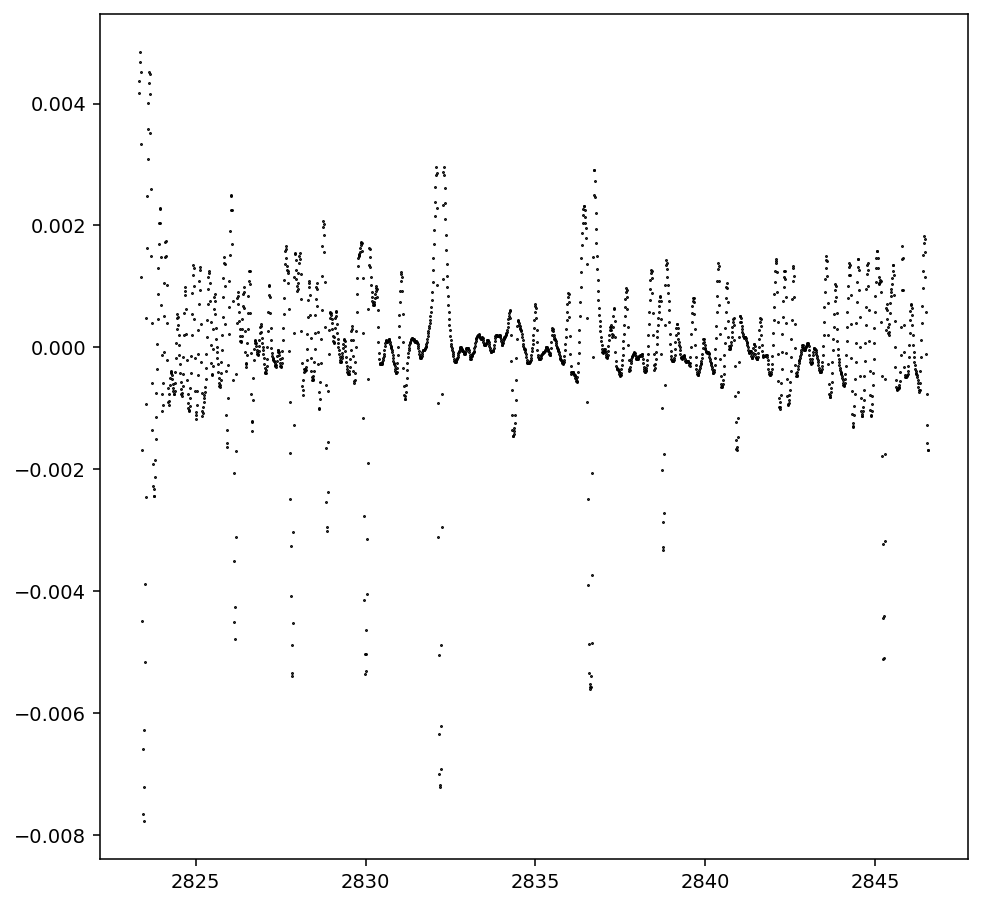

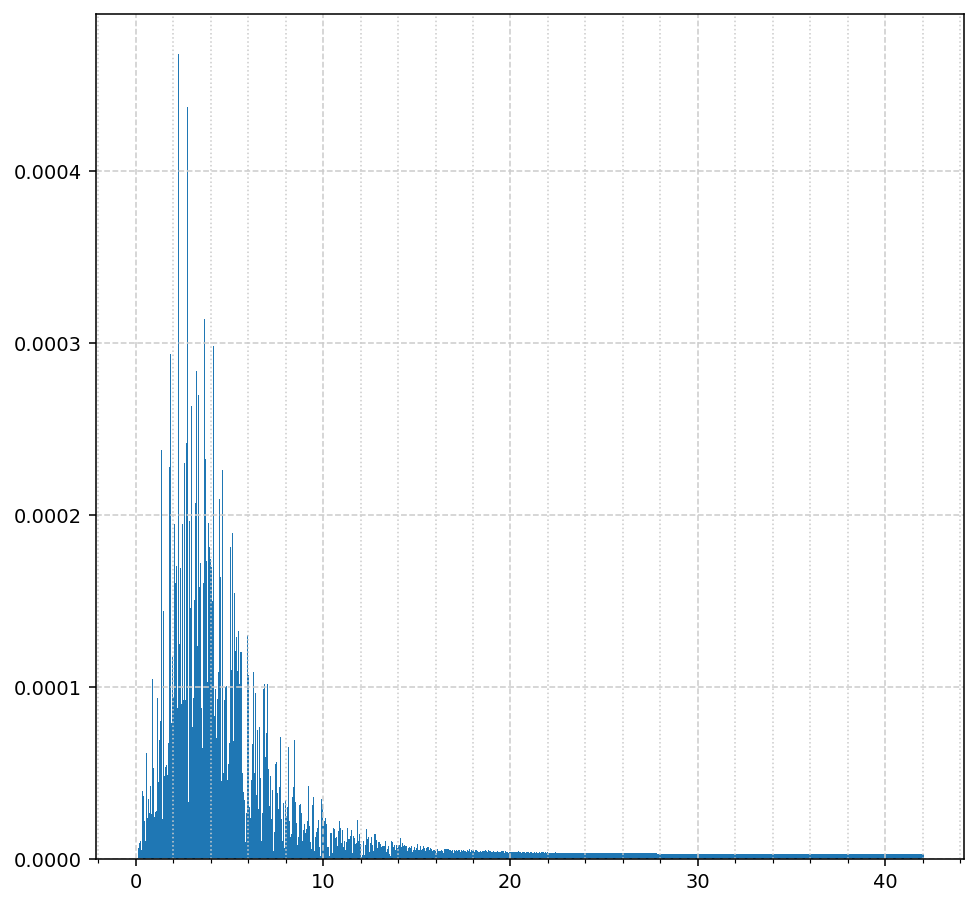

In [31]:
frequencies, transformed_flat = perform_fft(new_x, flattened_curve, period)

In [32]:
best_freq = frequencies[np.where(transformed_flat == max(transformed_flat))[0]][0]
print(best_freq)

time_period = 1 / best_freq
time_period

2.281436393307393


0.43832035069375846

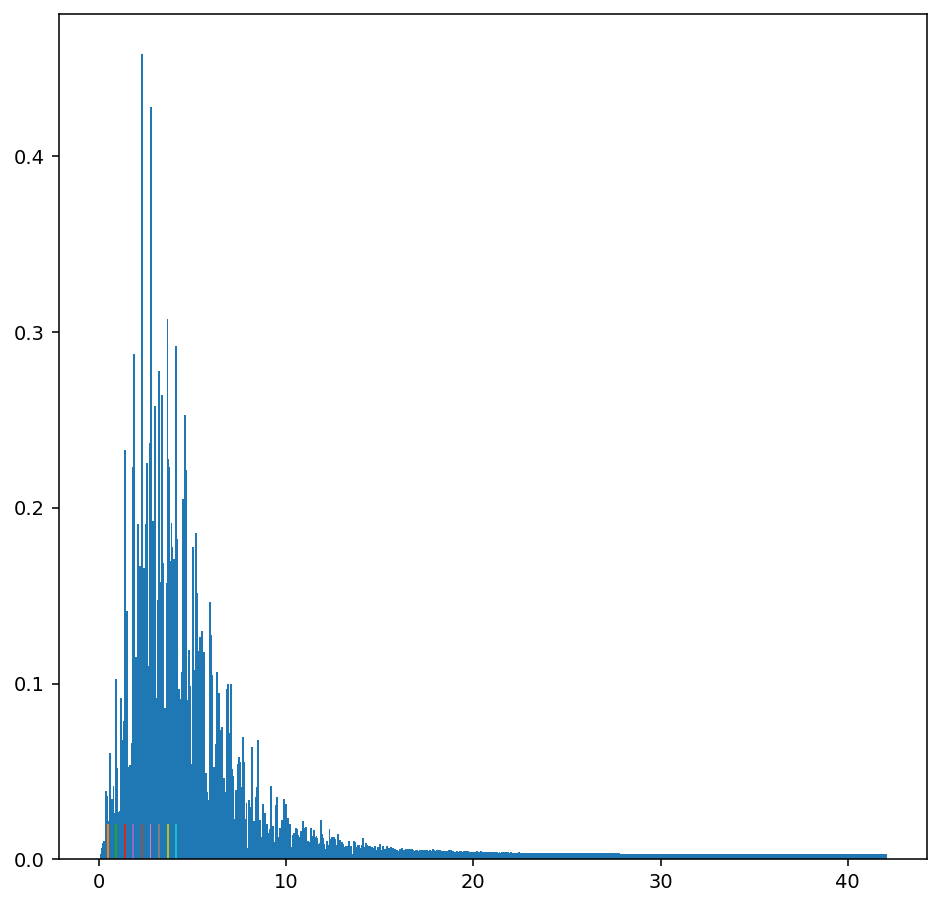

In [33]:
fig, ax = plt.subplots()
ax.bar(frequencies, transformed_flat, width=0.1)

for i in range(1, 10):
    ax.bar([1/(2.18/i)], [0.02], width=0.1)

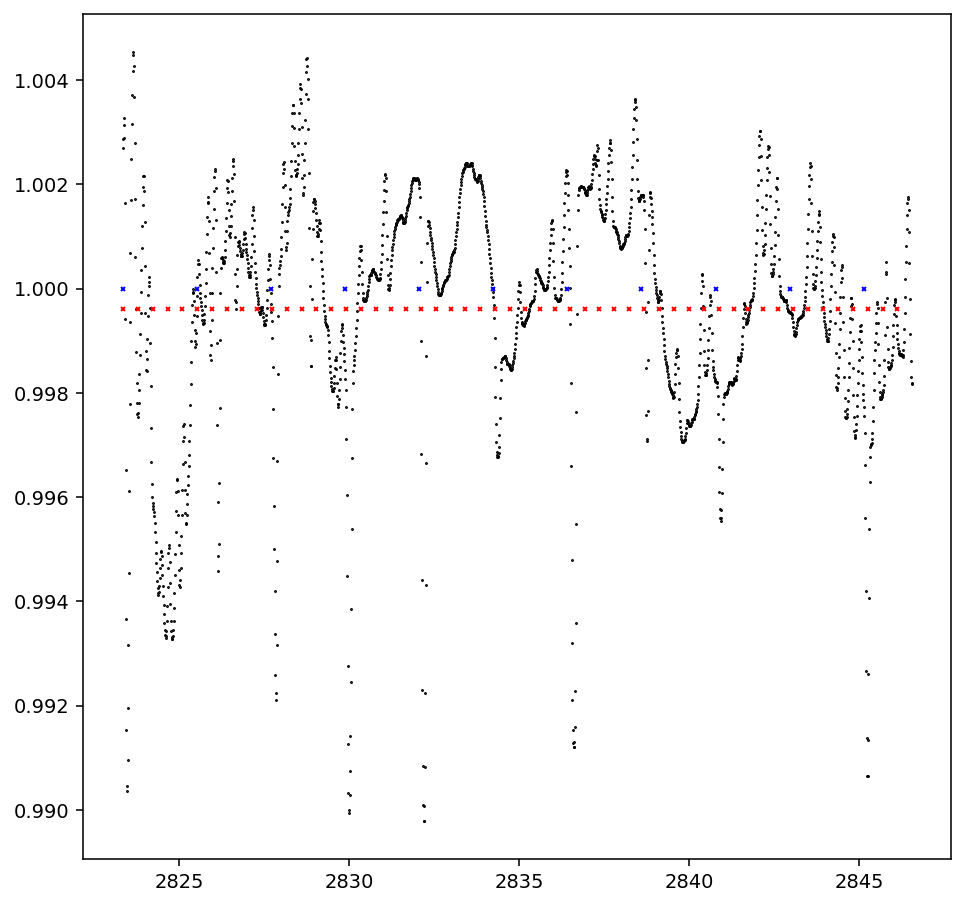

In [34]:
fig, ax = plt.subplots()
ax.plot(new_x, gaussian_smoothed, 'k.', markersize=1)
freq_x = np.arange(new_x[0], new_x[-1], time_period)
freq_y = np.full((len(freq_x),), average(gaussian_smoothed), dtype=float)
ax.plot(freq_x, freq_y, 'rx', markersize=2)

actual_time_period = 2.18
freq_x = np.arange(new_x[0], new_x[-1], actual_time_period)
freq_y = np.full((len(freq_x),), 1)
ax.plot(freq_x, freq_y, 'bx', markersize=2)

0.43832035069375846


<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

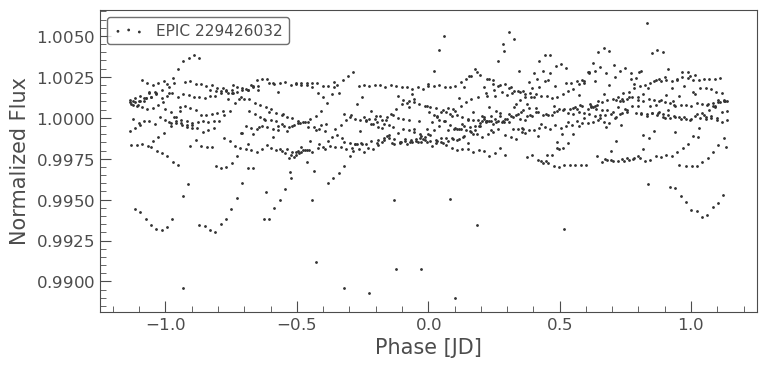

In [35]:
print(time_period)
folded = lightcurve.fold(period=best_freq)
folded.scatter()
## not a very good one

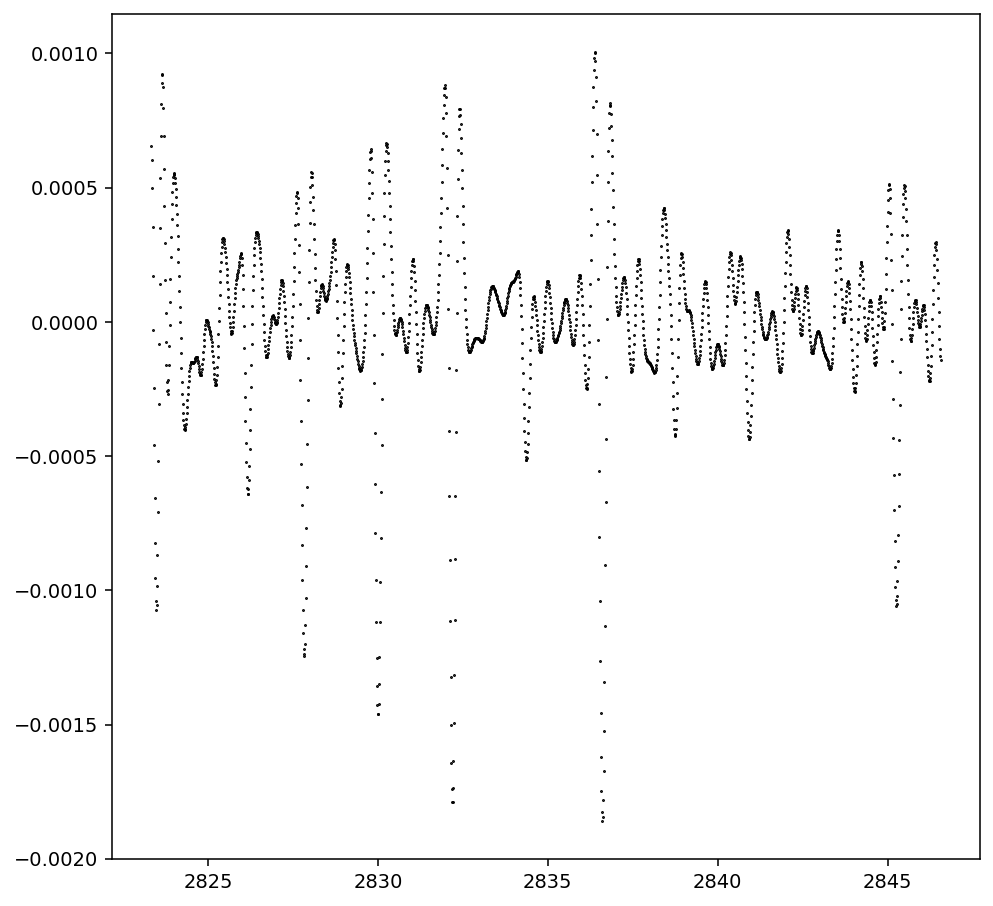

In [36]:
gauss_flattened = gaussian_smooth(flattened_curve, sigma=8)
plot_ts(new_x, gauss_flattened)

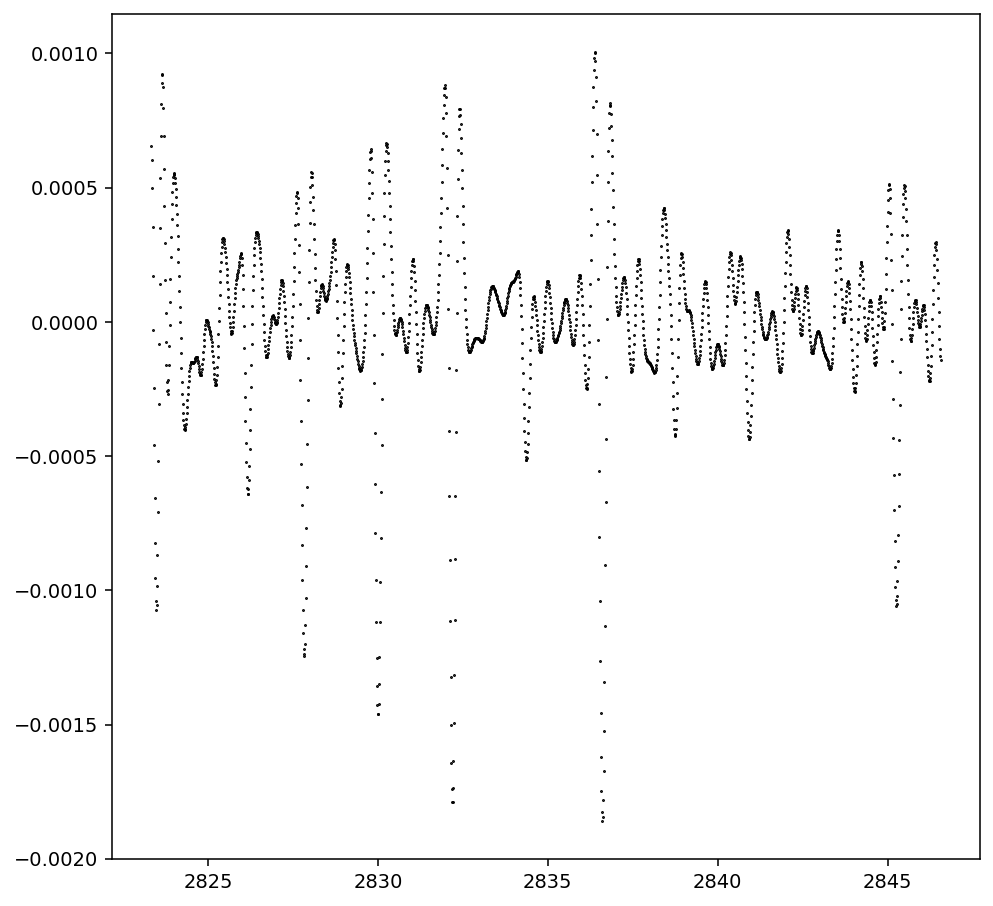

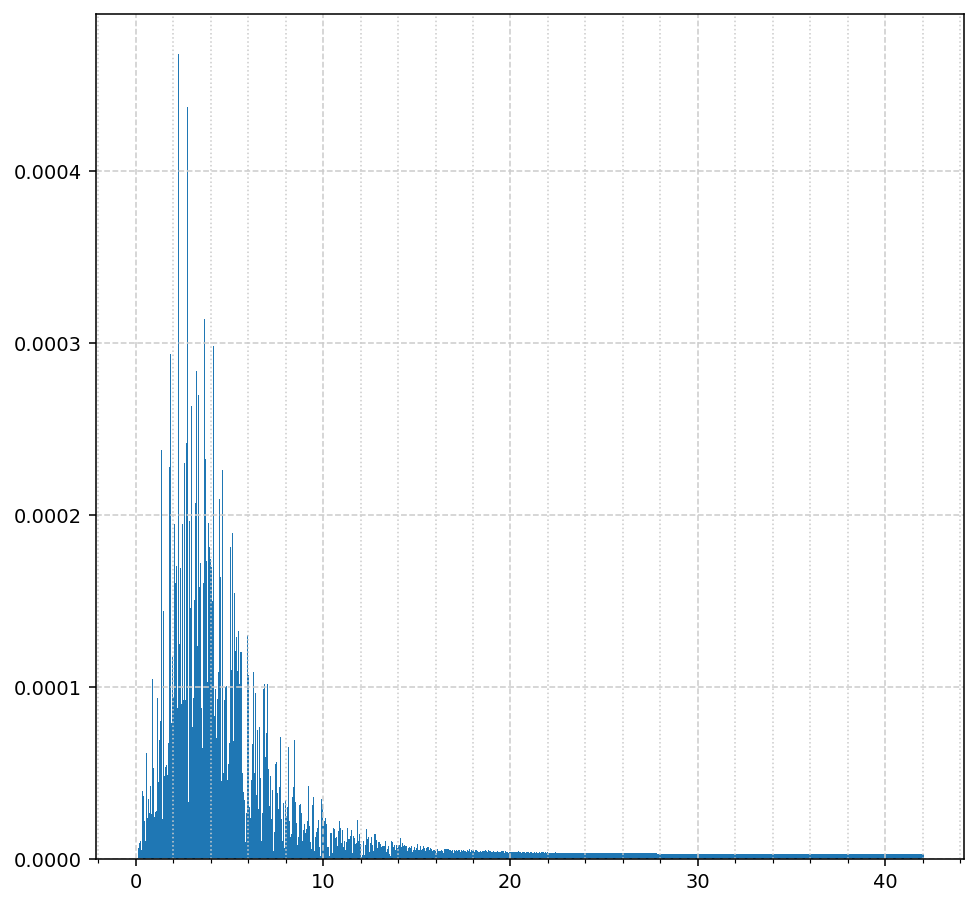

In [37]:
frequencies, transformed_flat_smooth = perform_fft(new_x, gauss_flattened, period)

In [38]:
best_freq_smoothed = frequencies[np.where(transformed_flat_smooth == max(transformed_flat_smooth))[0]][0]
print(best_freq_smoothed)
     
time_period = 1 / best_freq_smoothed
time_period

2.281436393307393


0.43832035069375846

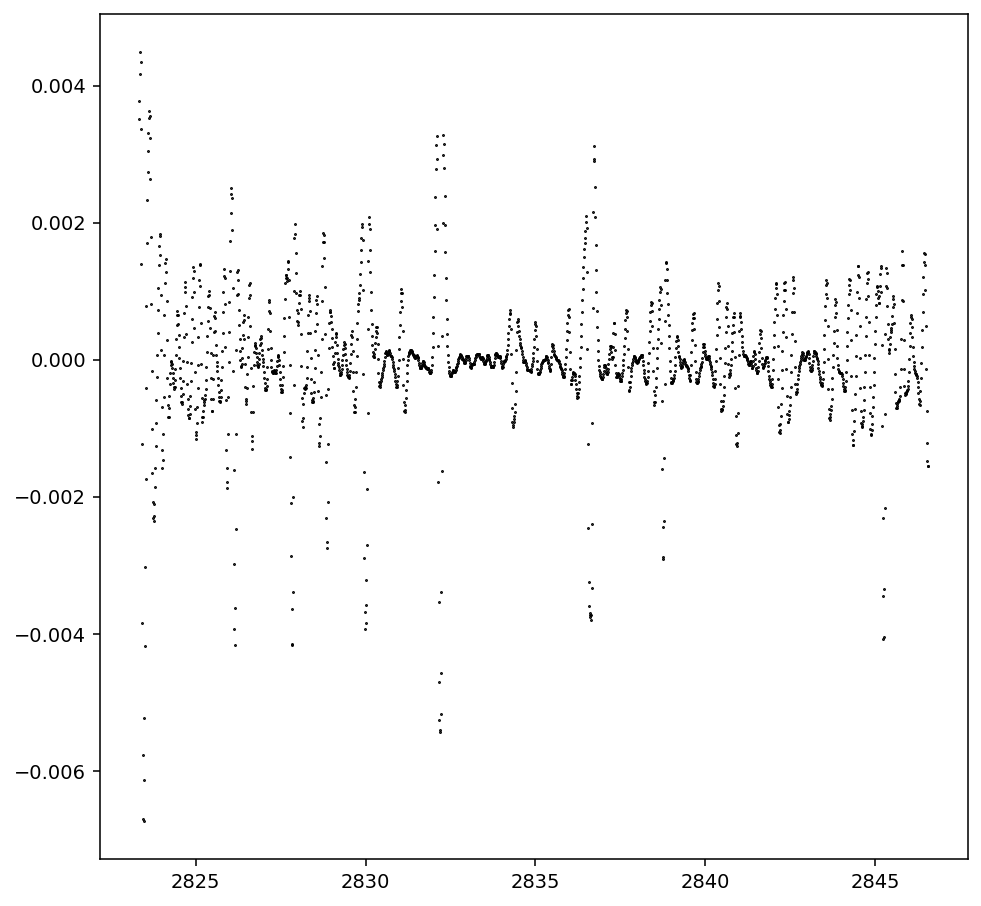

In [39]:
supersmooth = flattened_curve - gauss_flattened

plot_ts(new_x, supersmooth)

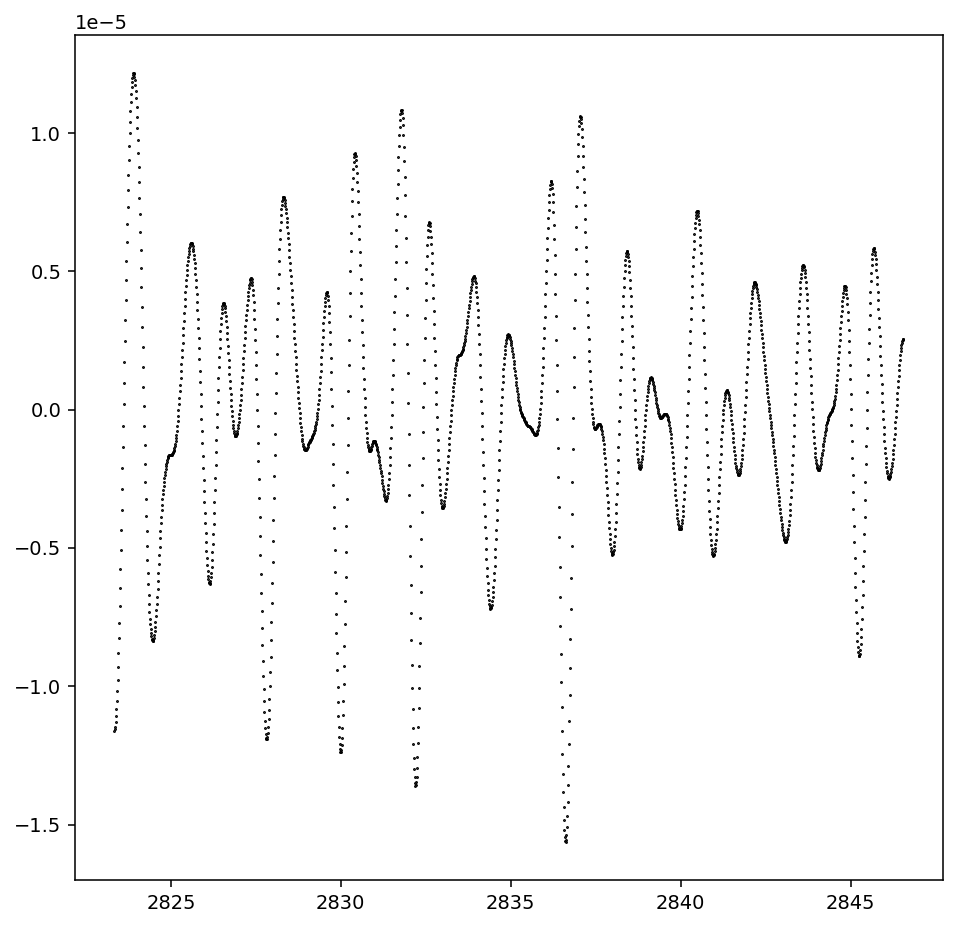

In [40]:
supersupersmooth = gaussian_smooth(supersmooth, sigma=25)

plot_ts(new_x, supersupersmooth)

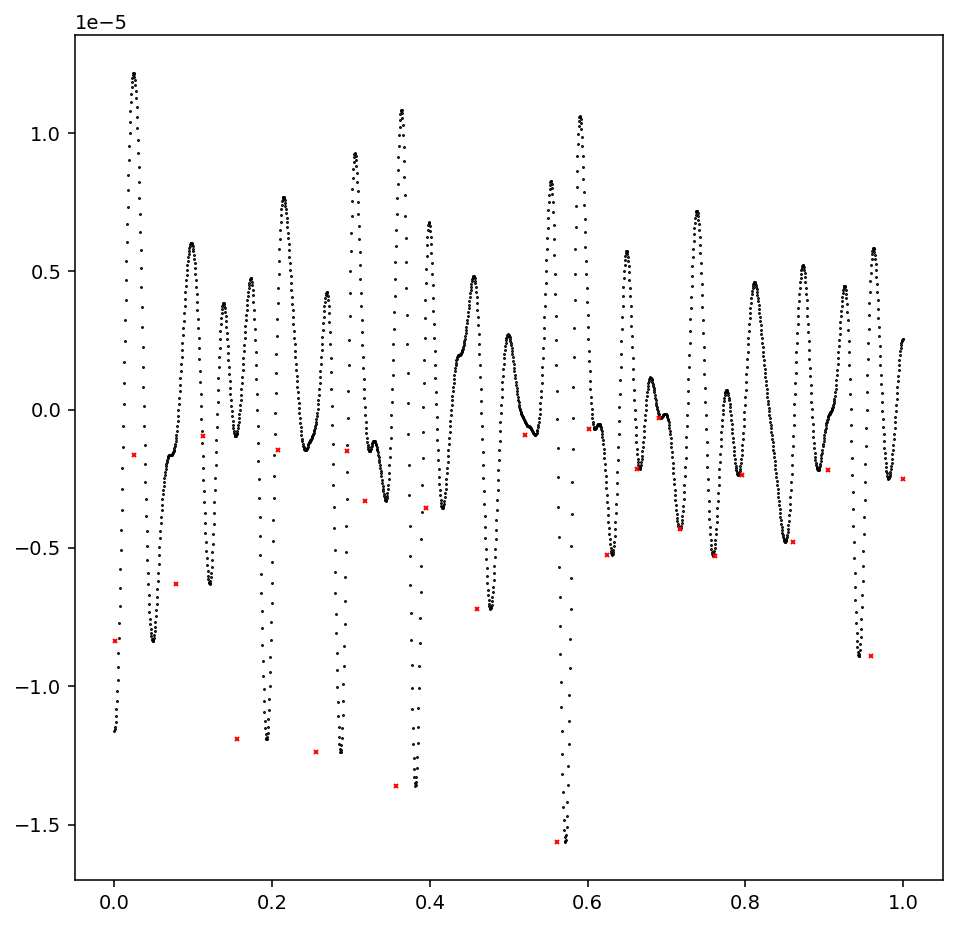

In [41]:
peaks, properties = find_peaks(supersupersmooth*-1)
fig, ax = plt.subplots()
ax.plot(newnew_x, supersupersmooth, 'k.', markersize=1)
ax.plot((peaks - peaks[0] + 1) / (peaks[-1]-peaks[0]), supersupersmooth[peaks], 'rx', markersize=2)

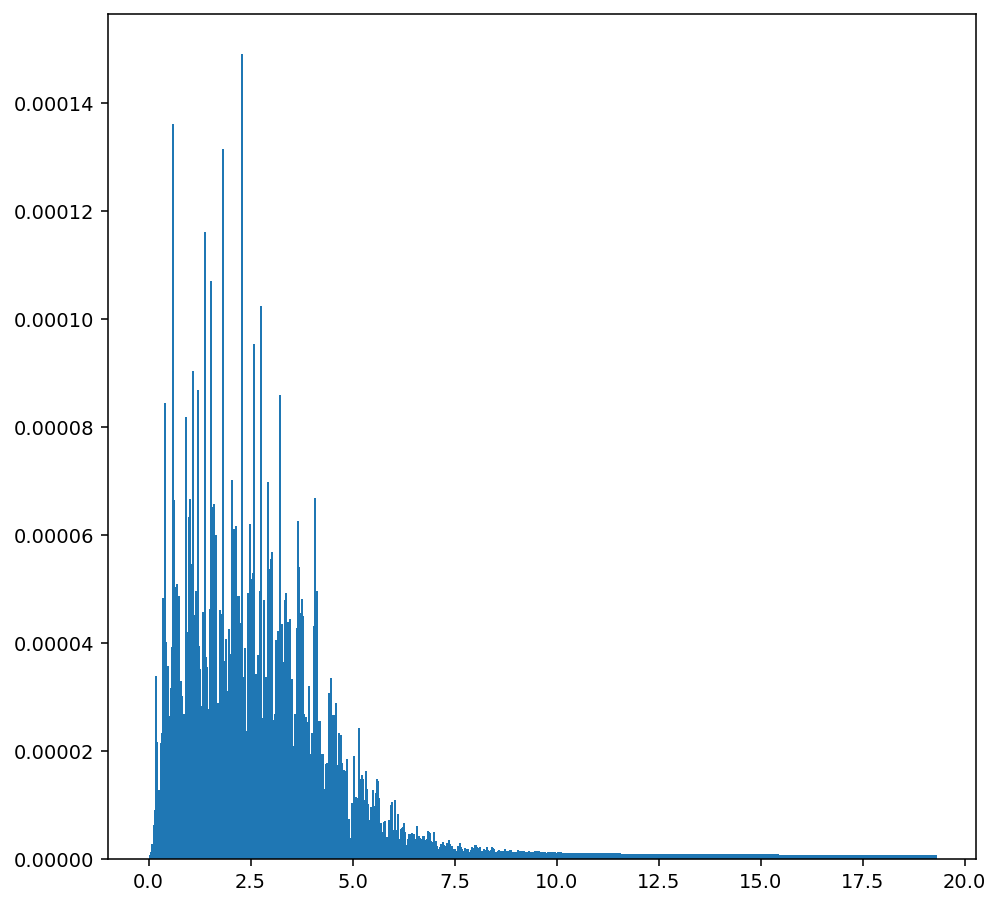

In [44]:
frequencies, transformed_supersupersmooth = perform_fft(new_x, supersupersmooth, period, plottimeseries=False)

In [45]:
ordered_supersmooth = sorted(transformed_supersupersmooth)
supersmooth_freq = frequencies[np.where(transformed_supersupersmooth == ordered_supersmooth[-1])[0]][0]
print(supersmooth_freq)

time_period = 1 / supersmooth_freq
time_period

2.292749577637474


0.43615753318791733

<BarContainer object of 715 artists>

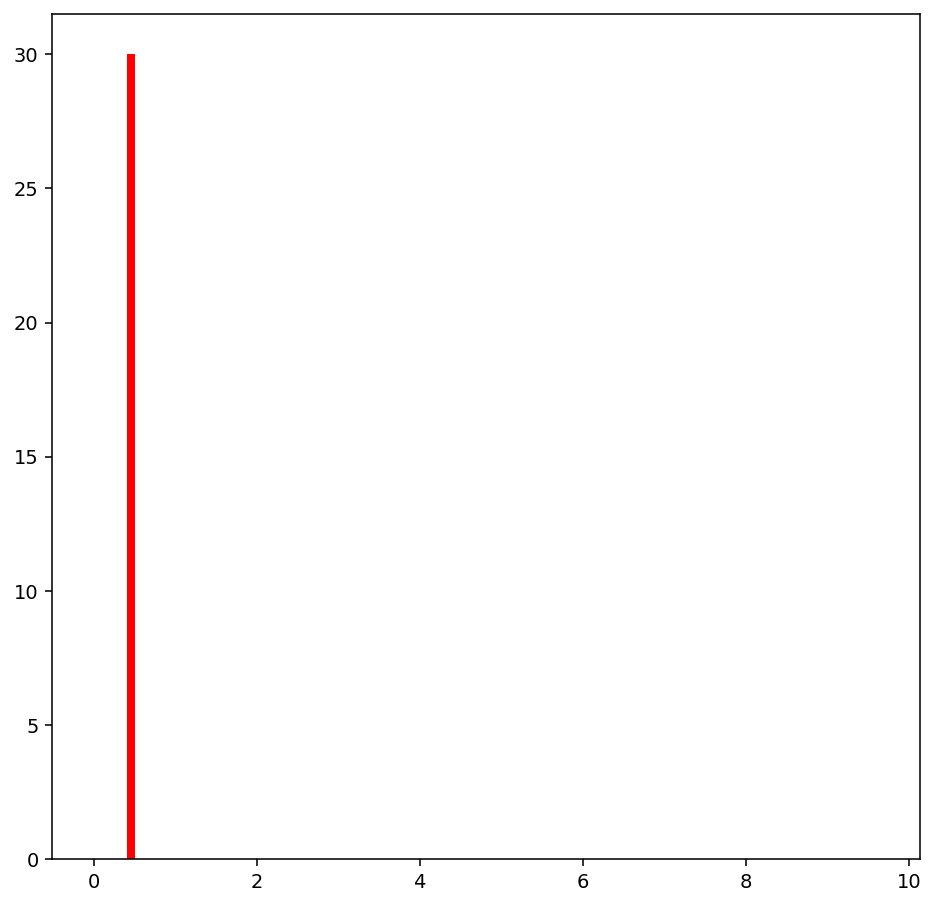

In [46]:
fig, ax = plt.subplots()
ax.bar([1/2.18], [30], width=0.1,color='r')
ax.bar(frequencies[:len(frequencies)//2], 2.0 / len(new_x) * transformed_supersupersmooth[:len(frequencies)//2], width=0.05, color='b')


2.292749577637474


<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

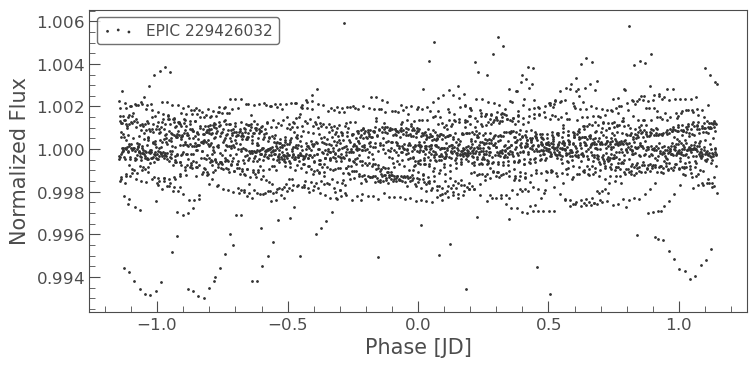

In [52]:
print(supersmooth_freq)
folded = lightcurve.fold(period=supersmooth_freq)
folded.scatter()

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

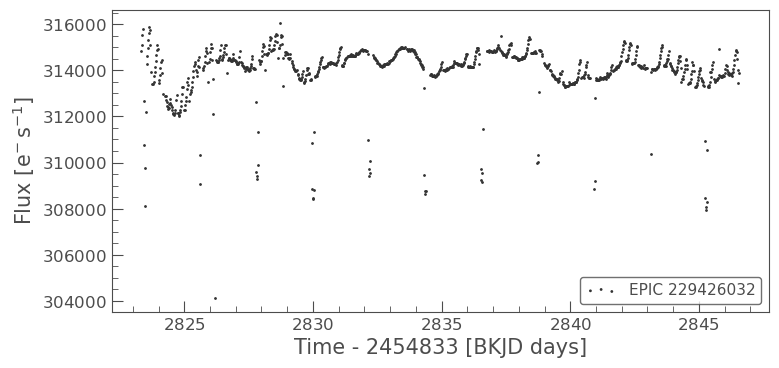

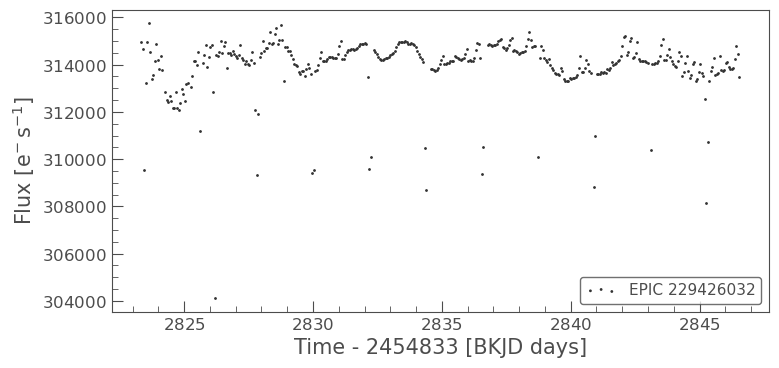

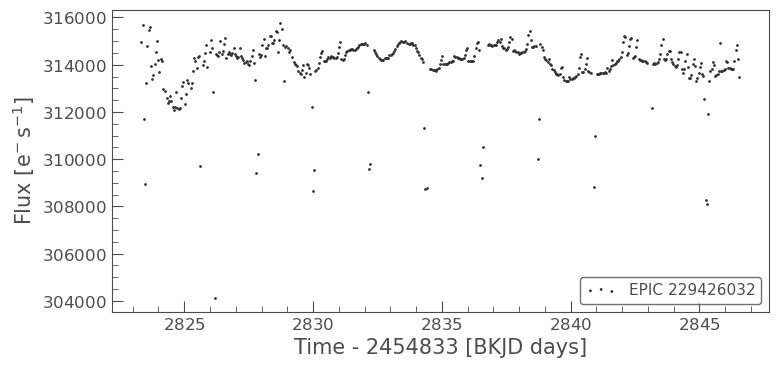

In [48]:
lightcurves[0].scatter()
binned = lightcurves[0].bin(bins=400)
binned.scatter()
binned = lightcurves[0].bin(bins=500)
binned.scatter()

# lightcurve.scatter()

# times = lightcurve['time'].value
# flux = lightcurve['flux'].unmasked.value

# # print(len(flux))
# # print(np.count_nonzero(flux))
# # times, flux = clean_nan_from_ts(times, flux)
# # times, flux = remove_outliers(times, flux)

# # fig, ax = plt.subplots()
# # ax.plot(times, fluxes, 'k.')

# times_cropped = [times[times<=3000], times[(times>3000) & (times<=4000)], times[times>4000], times[(times>3793) & (times<3800)], times[(times>2875) & (times<2880)]]
# fluxes_cropped = [flux[times<=3000], flux[(times>3000) & (times<=4000)], flux[times>4000], flux[(times>3793) & (times<3800)], flux[(times>2875) & (times<2880)]]

# # ax.plot(times,flux,'k.')

# for i in range(len(times_cropped)):
#     fig, ax = plt.subplots()
#     ax.plot(times_cropped[i], fluxes_cropped[i], 'k.', markersize=1)
#     index = np.where(fluxes_cropped[i] == min(fluxes_cropped[i]))[0][0]
#     ax.plot(times_cropped[i][index], fluxes_cropped[i][index], 'g.')

# # # for curve in lightcurves:
# # #     curve.plot()

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

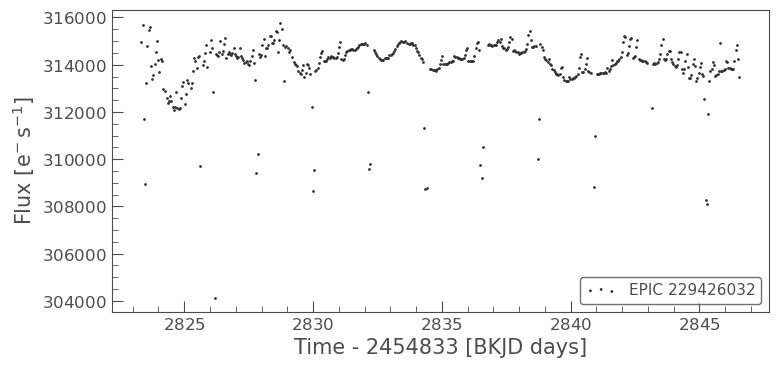

In [49]:
binned.scatter()

In [8]:
times = lightcurve['time'].value
flux = lightcurve['flux'].unmasked.value

print(len(flux))
print(np.count_nonzero(np.isnan(flux)))
nans = np.where(np.isnan(flux))[0]
print(len(nans), nans)
for to_remove in reversed(nans):
    times = np.delete(times, to_remove)
    flux = np.delete(flux, to_remove)

flux

NameError: name 'lightcurve' is not defined

In [ ]:
# lightcurve = lightcurve.remove_outliers()
estimated_big_orbit_p = (3793.016468689744 - 2875.007092390282) / 32
known_p = 2.18053539

# prefiltered_folded = lightcurve_prefiltered.fold(period=known_p)
# prefiltered_folded.scatter()
# prefiltered_folded.plot()

# prepostfiltered_folded = lightcurve_prepostfiltered.fold(period=known_p)
# prepostfiltered_folded.scatter()
# prepostfiltered_folded.plot()

postfiltered_folded = lightcurve_postfiltered.fold(period=known_p)
postfiltered_folded.scatter()
# postfiltered_folded.plot()

# times = folded['time'].value
# flux = folded['flux'].unmasked.value

In [ ]:
fluxes = lightcurve['flux'].unmasked.value
times = lightcurve['time'].value

rolling_ave_flux = moving_average(fluxes, n=200)

fig, ax = plt.subplots()
ax.plot(times, fluxes, 'k.')

In [ ]:
split = round(len(lightcurve) / 5)
for i in range(5):
    lightcurve[i * split: min(len(lightcurve), (i+1) * split)].scatter()

In [ ]:
lightcurve = lightcurve_postfiltered

times = lightcurve['time'].value
fluxes = lightcurve['flux'].unmasked.value

zipped = sorted(list(zip(fluxes, times)), key=lambda x:x[1])
fluxes, times = zip(*zipped)

known_orbital_period = 2.18053539 #days
starting_time = times[0]

normal_fig, normal_ax = plt.subplots()
# ave_fig, ave_ax = plt.subplots()

# chosen = np.random.randint(0, 136)

folds = []
smoothed_folds = []

count = 1
print("orbital p" , known_orbital_period * count)
next_val = next((i for i in times if i > (known_orbital_period * count) + starting_time), None)
last_index = 0
while next_val is not None:
    index = np.where(times == next_val)[0][0]
    if index - last_index <= 1:
        count += 1
        next_val = next((i for i in times if i > (known_orbital_period * count) + starting_time), None)
        continue
    folded_times = times[last_index:index]
    folded_fluxes = fluxes[last_index:index]

#     folded_times, folded_fluxes = clean_nan_from_ts(folded_times, folded_fluxes)
    
    normalised_fluxes = normalise(folded_fluxes)
    rolling_ave = moving_average(normalised_fluxes)
    centre = np.where(rolling_ave == min(rolling_ave))[0][0]
    
#     if count == 1:
#         if centre < len(folded_times) / 4:
#             index -= round(len(folded_times) / 4)
#         elif centre > (3 * len(folded_times)) / 4:
#             index += round(len(folded_times) / 4)
#         folded_times = times[last_index:index]
#         folded_fluxes = fluxes[last_index:index]
#         normalised_fluxes = normalise(folded_fluxes)
#         rolling_ave = moving_average(normalised_fluxes)
#         centre = np.where(rolling_ave == min(rolling_ave))[0][0]
    
    if np.count_nonzero(normalised_fluxes) == 0:
        print(normalised_fluxes, count, index, last_index)
        print(folded_fluxes)
        last_index = index
        count += 1
        next_val = next((i for i in times if i > (known_orbital_period * count) + starting_time), None)
        continue
    
    normalised_times = folded_times - folded_times[0]
    
    sigma = 2
    
    gaussian_smoothed_time = ndimage.gaussian_filter1d(normalised_times, sigma)
    gaussian_smoothed_flux = ndimage.gaussian_filter1d(normalised_fluxes, sigma)

#     var = np.var(normalised_fluxes)
#     fig, ax = plt.subplots()
#     ax.plot(normalised_times, normalised_fluxes, 'k.', label=f"Var={var}")
#     ax.plot(normalised_times, rolling_ave, 'r.', label="Rolling ave")
#     ax.plot(gaussian_smoothed_time, gaussian_smoothed_flux, 'g.', label="Gaussian")
#     ax.legend(bbox_to_anchor=(1, 1))
#     plt.close(fig)
       
    col = (np.random.random(), np.random.random(), np.random.random())
#     normal_ax.plot(normalised_times, normalised_fluxes, '.', c=col, label=str(count), markersize=0.5)

    folds += list(zip(normalised_times, normalised_fluxes))
    smoothed_folds += list(zip(normalised_times, rolling_ave))
    
    last_index = index
    count += 1
    next_val = next((i for i in times if i > (known_orbital_period * count) + starting_time), None)
    
folds = sorted(folds, key=lambda x:x[0])
smoothed_folds = sorted(smoothed_folds, key=lambda x:x[0])

times, fluxes = zip(*folds)
smooth_times, smooth_fluxes = zip(*smoothed_folds)

normal_ax.plot(times, fluxes, 'k.', markersize=1)

smooth_fig, smooth_ax = plt.subplots()
smooth_ax.plot(smooth_times, smooth_fluxes, 'k.', markersize=1)


In [ ]:
extrasmooth_fig, extrasmooth_ax = plt.subplots()
# extrasmooth_fluxes = moving_average_same_dimensions(smooth_fluxes, n=500)
sigma = 10
gaussian_smoothed_flux = ndimage.gaussian_filter1d(smooth_fluxes, sigma)

extrasmooth_ax.plot(smooth_times, gaussian_smoothed_flux, 'k.', markersize=1)

In [ ]:
lightcurve = lightcurve_postfiltered

times = lightcurve['time'].value
fluxes = lightcurve['flux'].unmasked.value

zipped = sorted(list(zip(fluxes, times)), key=lambda x:x[1])
fluxes, times = zip(*zipped)

known_orbital_period = 2.18053539 #days
starting_time = times[0]

normal_fig, normal_ax = plt.subplots()

vars = []
folds = []
smoothed_folds = []

count = 1
next_val = next((i for i in times if i > (known_orbital_period * count) + starting_time), None)
last_index = 0
while next_val is not None:
    index = np.where(times == next_val)[0][0]
    if index - last_index <= 1:
        count += 1
        next_val = next((i for i in times if i > (known_orbital_period * count) + starting_time), None)
        continue
    folded_times = times[last_index:index]
    folded_fluxes = fluxes[last_index:index]

#     folded_times, folded_fluxes = clean_nan_from_ts(folded_times, folded_fluxes)
    
    normalised_fluxes = normalise(folded_fluxes)
    rolling_ave = moving_average(normalised_fluxes)
    centre = np.where(rolling_ave == min(rolling_ave))[0][0]
    
#     if count == 1:
#         if centre < len(folded_times) / 4:
#             index -= round(len(folded_times) / 4)
#         elif centre > (3 * len(folded_times)) / 4:
#             index += round(len(folded_times) / 4)
#         folded_times = times[last_index:index]
#         folded_fluxes = fluxes[last_index:index]
#         normalised_fluxes = normalise(folded_fluxes)
#         rolling_ave = moving_average(normalised_fluxes)
#         centre = np.where(rolling_ave == min(rolling_ave))[0][0]
    
    if np.count_nonzero(normalised_fluxes) == 0:
        print(normalised_fluxes, count, index, last_index)
        print(folded_fluxes)
        last_index = index
        count += 1
        next_val = next((i for i in times if i > (known_orbital_period * count) + starting_time), None)
        continue
    
    normalised_times = folded_times - folded_times[0]
    
    if normalised_times[-1] > 2.4:
        fig, ax = plt.subplots()
        ax.plot(normalised_times, folded_fluxes, 'k.')
        print(count, index, times[last_index])
    
    sigma = 2
    
#     gaussian_smoothed_time = ndimage.gaussian_filter1d(normalised_times, sigma)
#     gaussian_smoothed_flux = ndimage.gaussian_filter1d(normalised_fluxes, sigma)

#     var = np.var(normalised_fluxes)
#     fig, ax = plt.subplots()
#     ax.plot(normalised_times, normalised_fluxes, 'k.', label=f"Var={var}")
#     ax.plot(normalised_times, rolling_ave, 'r.', label="Rolling ave")
#     ax.plot(gaussian_smoothed_time, gaussian_smoothed_flux, 'g.', label="Gaussian")
#     ax.legend(bbox_to_anchor=(1, 1))
#     plt.close(fig)
       
    col = (np.random.random(), np.random.random(), np.random.random())
#     normal_ax.plot(normalised_times, normalised_fluxes, '.', c=col, label=str(count), markersize=0.5)

#     folds += list(zip(normalised_times, normalised_fluxes))
#     smoothed_folds += list(zip(normalised_times, rolling_ave, 'k.'))
    
    # vars.append(var)
    last_index = index
    count += 1
    next_val = next((i for i in times if i > (known_orbital_period * count) + starting_time), None)
    
# folds = sorted(folds, key=lambda x:x[0])
# smoothed_folds = sorted(smoothed_folds, key=lambda x:x[0])

# times, fluxes = zip(*folds)
# smooth_times, smooth_fluxes = zip(*smoothed_folds)

# normal_ax.plot(times, fluxes, 'k.', markersize=1)

# smooth_fig, smooth_ax = plt.subplots()
# normal_ax.plot(smooth_times, smooth_fluxes, 'r.', markersize=1)
# smooth_ax.plot(smooth_times, smooth_fluxes, 'k.', markersize=1)

In [ ]:
len(smooth_fluxes)

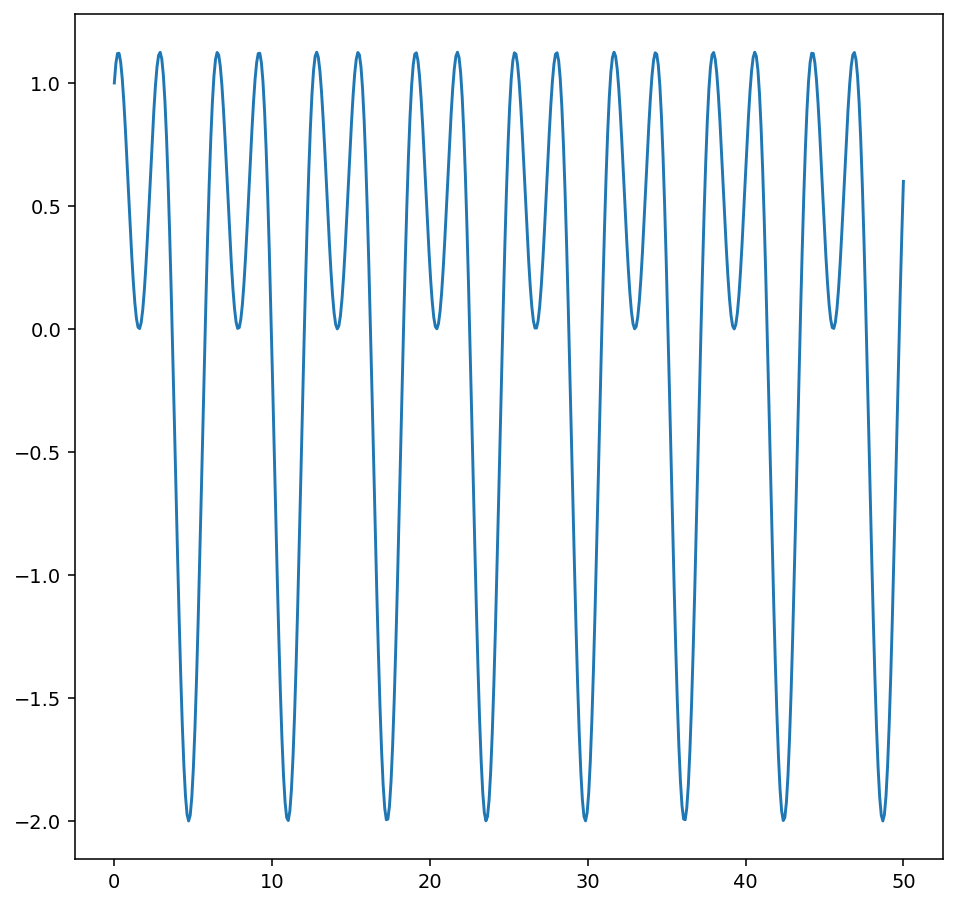

In [74]:
N = 500
T = 0.1
sin_x = np.linspace(0.0, N*T, N)
sin_y = np.sin(sin_x) +  np.cos(2*sin_x)
fig, ax = plt.subplots()
ax.plot(sin_x, sin_y)

<BarContainer object of 250 artists>

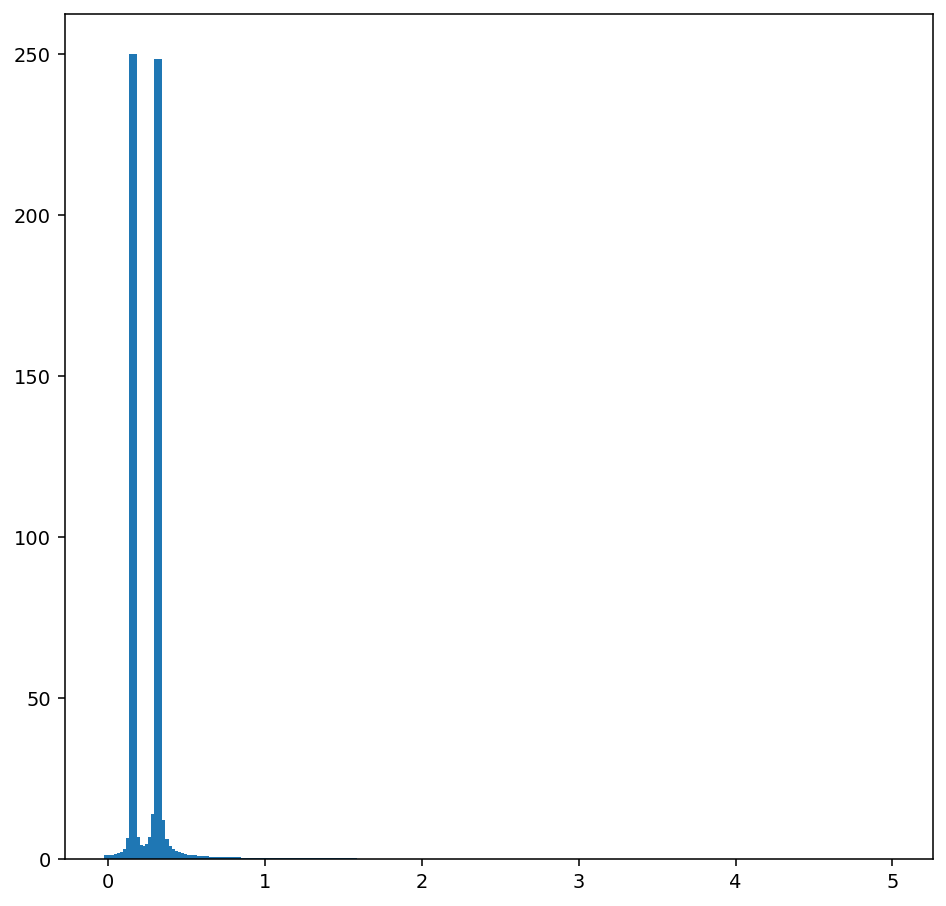

In [75]:
transform = np.abs(fft(sin_y)[:N//2])
freq = fftfreq(N, T)[:N//2]

fig, ax = plt.subplots()
ax.bar(freq, transform, width=0.05)

In [76]:
best_freq = freq[np.where(transform == max(transform))[0]][0]
print(best_freq)

time_period = 1 / best_freq
print(time_period)
print(np.pi * 2)

0.16
6.25
6.283185307179586


In [80]:
ordered = sorted(transform)
second_best = freq[np.where(transform == ordered[-2])[0]][0]
print(second_best)

second_best_tp = 1/ second_best
print(second_best_tp)

0.32
3.125


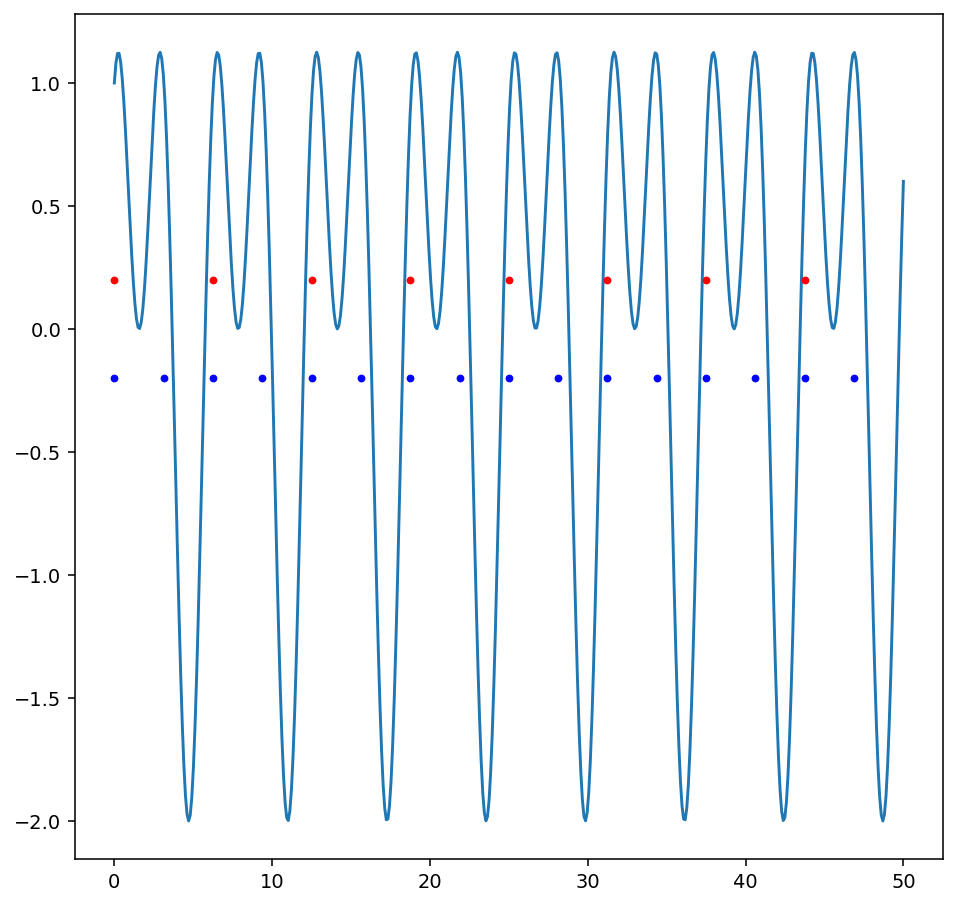

In [85]:
fig, ax = plt.subplots()
ax.plot(sin_x, sin_y)

freq_x = np.arange(sin_x[0], sin_x[-1], time_period)
freq_y = np.full(len(freq_x), 0.2)
ax.plot(freq_x, freq_y, 'r.')

freq_x = np.arange(sin_x[0], sin_x[-1], second_best_tp)
freq_y = np.full(len(freq_x), -0.2)
ax.plot(freq_x, freq_y, 'b.')

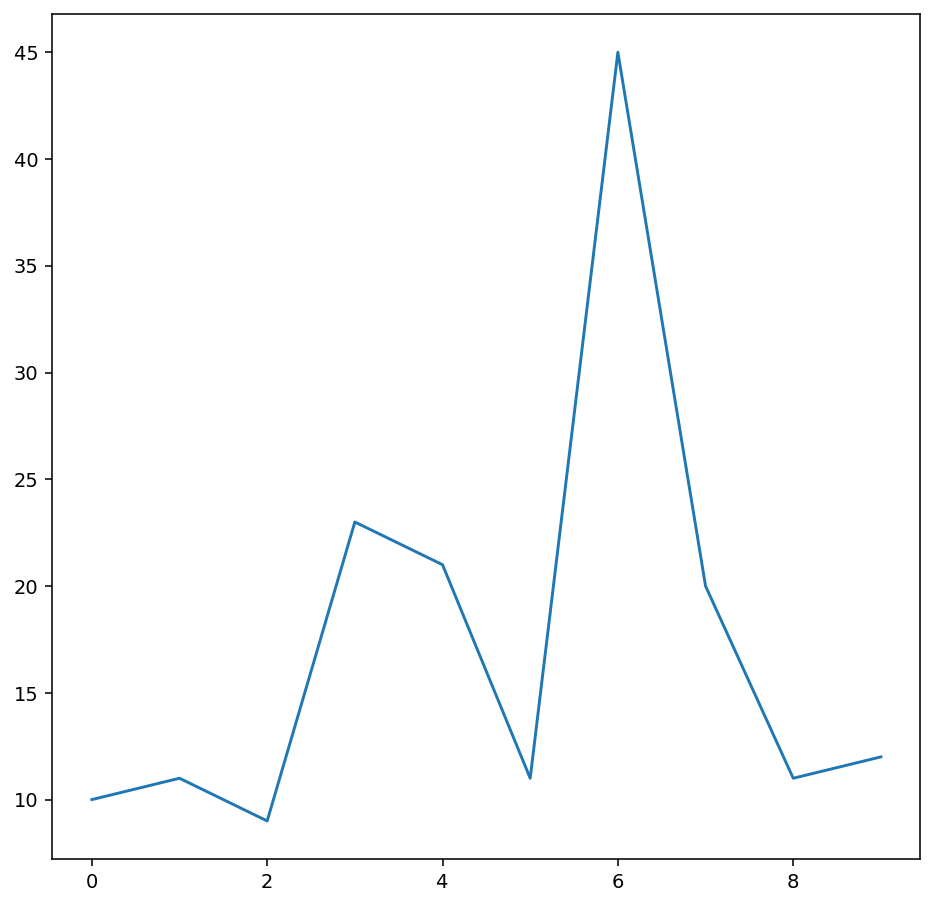

In [90]:
a = np.array([10,11,9,23,21,11,45,20,11,12])
fig, ax = plt.subplots()
ax.plot(np.arange(0, len(a), 1), a)